In [ ]:
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque
import torch.optim as optim
import copy

# Multi-armed bandit: slot machines

In [15]:
class Slots():
    def __init__(self, n_machines=5, rwin=1.0, rloss=-1.0, max_rounds=200, seed=None):
        self.n_machines = n_machines
        self.rwin = rwin
        self.rloss = rloss
        self.max_rounds = max_rounds

        # Initialize the probabilities of winning for each machine
        if seed is None:
            self.probs = np.random.rand(self.n_machines)
        elif seed == 0:
            self.probs = [0.1 for _ in range(self.n_machines)]
            np.random.seed(0)
            self.probs[np.random.randint(0, self.n_machines)] = 0.9
        else:
            np.random.seed(seed)
            self.probs = np.random.rand(self.n_machines)
        # print("Slot machine probabilities:", self.probs)
        self.reset()

    def reset(self):
        self.state = np.zeros((self.n_machines, 3), dtype=np.float32)
        self.state[:, 2] = self.max_rounds  # Remaining rounds for each machine
        self.t = 0
        return self.state.copy()
    
    def step(self, action):
        # Take an action and update the environment state. Returns next state, reward, done
        if action < 0 or action >= self.n_machines:
            raise ValueError("Invalid action:")
        
        # Increment global step for each machine
        self.state[:, 2] -= 1
        
        # Increment number of times the machine was chosen
        self.state[action][0] += 1

        # Win or lose according to real probabilities
        if np.random.rand() < self.probs[action]:
            self.state[action][1] += 1
            reward = self.rwin
        else:
            reward = self.rloss

        self.t += 1
        done = self.t >= self.max_rounds
        return self.state.copy(), reward, done, {}
    
    def get_state(self):
        return self.state.copy()

## Network

In [16]:
neuron_factor = 3

In [17]:
# Base DQN

class DQN_FC(nn.Module):
    def __init__(self, n_machines):
        super(DQN_FC, self).__init__()
        self.n_machines = n_machines
        in_dim = self.n_machines * 3
        self.fc1 = nn.Linear(in_dim, in_dim * neuron_factor)
        self.fc2 = nn.Linear(in_dim*neuron_factor, in_dim * neuron_factor)
        self.fc3 = nn.Linear(in_dim*neuron_factor, n_machines)
        
    def forward(self, state):
        state = nn.Flatten()(state)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

In [18]:
# Permutation Equivariant DQN

class DQN_Equivariant(nn.Module):
    def __init__(self, n_machines):
        super(DQN_Equivariant, self).__init__()
        self.n_machines = n_machines
        hidden_size = n_machines * neuron_factor
        # Shared MLP for each machine's state (each state is of dim 3)
        self.phi = nn.Sequential(
            nn.Linear(3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Final layer to compute Q-values
        self.f = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, state):
        # state: batch_size x n_machines x 2
        batch_size = state.size(0)

        # Compute local features for each machine (batch_size x n_machines x hidden_size)
        phi_out = self.phi(state)
        
        # Compute global context (here using sum) over machines (batch_size x hidden_size)
        global_context = phi_out.sum(dim=1)
        
        # Create tensor of shape batch_size x n_machines x hidden_size
        global_context_expanded = global_context.unsqueeze(1).repeat(1, self.n_machines, 1)
        
        # Concatenate local features with global context (batch_size x n_machines x hidden_sizex2)
        combined = torch.cat([phi_out, global_context_expanded], dim=-1)
        
        # Get Q-values (batch_size x n_machines x 1)
        q_values = self.f(combined)
        
        # Squeeze the last dimension; result: batch_size x n_machines
        return q_values.squeeze(-1)

In [19]:
class PESymetry(nn.Module):
    def __init__(self, in_dim = 5, out_dim = 32):
        super(PESymetry, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        # Pooling network
        self.rest =  nn.Linear(self.in_dim, self.out_dim, bias=False)
        # Individual network
        self.diagonal = nn.Linear(self.in_dim, self.out_dim)

    def forward(self, x):
        # x: batch_size x n_machines x in_dim
        # x_mean: 1 x n_machines x in_dim
        x_mean = x.mean(dim=0, keepdim=True)
        x_mean = self.rest(x_mean)
        # x_mean: 1 x n_machines x out_dim
        # x: batch_size x n_machines x out_dim
        x = self.diagonal(x)
        x = x + x_mean
        return x
    
class DQN_PESymetry(nn.Module):
    def __init__(self, n_machines = 5):
        super(DQN_PESymetry, self).__init__()
        self.n_machines = n_machines
        self.hidden_size = n_machines * neuron_factor

        self.network = nn.Sequential(
            PESymetry(3, self.hidden_size),
            # Activation
            nn.ELU(),
            PESymetry(self.hidden_size, self.hidden_size),
            nn.ELU(),
            PESymetry(self.hidden_size, 1),
        )
    
    def forward(self, state):
        # state: batch_size x n_machines x 3
        q_values = self.network(state)
        # q_values: batch_size x n_machines x 1
        return q_values.squeeze(-1)

In [20]:
class AttentionHead(nn.Module):
    def __init__(self, in_dim, att_dim=None, v_dim=None):
        super(AttentionHead, self).__init__()
        # Layer size
        self.in_dim = in_dim
        self.att_dim = att_dim if att_dim is not None else in_dim * 2
        self.v_dim = v_dim if v_dim is not None else in_dim * 2

        self.attention_layer = nn.Linear(in_dim, att_dim)
        self.value_layer = nn.Linear(in_dim, v_dim)

    def forward(self, x):
        # (B, N, in_dim) -> (B, N, att_dim)
        query = self.attention_layer(x)
        key = self.attention_layer(x)
        # (B, N, att_dim) -> (B, N, v_dim)
        value = self.value_layer(x)
        # (B, N, att_dim) x  (B, N, att_dim).T -> (B, N, N)
        qk = torch.matmul(query, key.transpose(-2, -1,))/np.sqrt(self.att_dim)
        attention_weights = nn.Softmax(dim=-1)(qk)
        # (B, N, N) x (B, N, v_dim) -> (B, N, v_dim)
        output = torch.matmul(attention_weights, value)
        return output

class DQN_AttPE(nn.Module):
    def __init__(self, n_machines = 5):
        super(DQN_AttPE, self).__init__()
        self.n_machines = n_machines
        self.hidden_size = n_machines * neuron_factor * 10

        # Shared MLP for each machine's state (each state is of dim 3)
        self.attention = AttentionHead(3, att_dim=self.hidden_size, v_dim=self.hidden_size)

        # Final layer to compute Q-values
        self.final_layer = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )
    
    def forward(self, x):
        # (B, N, 3) -> (B, N, hidden_size)
        output = self.attention(x)
        # (B, N, hidden_size) -> (B, N)
        q_values = self.final_layer(output).squeeze(-1)
        return q_values

## Training new

In [30]:
# Constants
n_machines = 10
rwin = 1.0
rloss = 0.0
max_rounds = 200
num_episodes = 1000
batch_size = 1
gamma = 1.0
epsilon_start = 0.1

min_epsilon = 0.1
learning_rate = 3e-5
# replay_buffer_capacity = 200

# Device setup
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print('Using device:', device)

dqn_models = {
    'fc': DQN_FC(n_machines),
    'eq': DQN_Equivariant(n_machines),
    'eq2': DQN_PESymetry(n_machines),
    'att': DQN_AttPE(n_machines),
}

for model in dqn_models.values():
    model.to(device)

dqn_optimizers = {}
dqn_target_models = {}

for name, model in dqn_models.items():
    dqn_optimizers[name] = optim.Adam(model.parameters(), lr=learning_rate)
    dqn_target_models[name] = copy.deepcopy(model)
    dqn_target_models[name].eval()

Using device: xpu


In [32]:
def select_action(model, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(state))  # n_machines
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # [1, n, 3]

        with torch.no_grad():
            q_values = model(state_tensor)
        return q_values.argmax().item()

def sample_batch(buffer, batch_size):
    batch = random.sample(buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return states, actions, rewards, next_states, dones

def compute_loss(model, target_model, batch):
    states, actions, rewards, next_states, dones = batch

    states_tensor = torch.FloatTensor(states).to(device)
    next_states_tensor = torch.FloatTensor(next_states).to(device)

    actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    dones_tensor = torch.FloatTensor(dones).unsqueeze(1).to(device)

    # Q(s, a) (dim batch x 1)
    # gather picks the q value based on the action taken
    q_values = model(states_tensor).gather(1, actions_tensor)

    # Target: r + γ * max_a' Q_target(s', a')
    # Get the max Q value for the next state from the target model (best action according to target model)
    with torch.no_grad():
        next_q_values = target_model(next_states_tensor).max(1, keepdim=True)[0]

    targets = rewards_tensor + gamma * next_q_values * (1 - dones_tensor)

    return F.mse_loss(q_values, targets)

In [35]:
# Training metrics
norm_rewards_evo, best_action_evo, loss_evo = {}, {}, {}
for name in dqn_models.keys():
    norm_rewards_evo[name] = []
    best_action_evo[name] = []
    loss_evo[name] = []

norm_rewards_evo['ts'] = []
best_action_evo['ts'] = []

all_delta_prob = []
all_max_steps = []

epsilon = epsilon_start

# Training loop
for episode in range(num_episodes):
    # Set same seed for each environment (reproducibility)
    seed = episode
    max_rounds = 100 + episode%100
    all_max_steps.append(max_rounds)

    # Environment init
    envs, states, replay_buffers, total_rewards, best_action_counts, total_loss = {}, {}, {}, {}, {}, {}
    for name in dqn_models.keys():
        envs[name] = Slots(n_machines=n_machines, rwin=rwin, rloss=rloss, max_rounds=max_rounds, seed=seed)
        states[name] = envs[name].reset()
        replay_buffers[name] = deque(maxlen=max_rounds)
        total_rewards[name] = 0.0
        best_action_counts[name] = 0
        total_loss[name] = 0.0
    # Add Thomas Sampling
    envs['ts'] = Slots(n_machines=n_machines, rwin=rwin, rloss=rloss, max_rounds=max_rounds, seed=seed)
    states['ts'] = envs['ts'].reset()
    total_rewards['ts'] = 0.0
    best_action_counts['ts'] = 0

    true_probs = envs['fc'].probs.copy()
    best_arm = np.argmax(true_probs)
    sorted_probs = np.sort(true_probs)[::-1]
    # Compute difference between two highest probabilities
    delta_prob = sorted_probs[0] - sorted_probs[1]
    all_delta_prob.append(delta_prob)

    ts_alpha, ts_beta = np.ones(n_machines), np.ones(n_machines)

    for t in range(max_rounds):
        
        # Train each DQN model
        for name, model in dqn_models.items():
            # Get action from policy
            action = select_action(model, states[name], epsilon)
            if action == best_arm:
                best_action_counts[name] += 1
            # Step
            next_state, reward, done, _ = envs[name].step(action)
            # Store reward
            total_rewards[name] += reward
            # Store state-action pair in replay buffer
            replay_buffers[name].append((states[name].copy(), action, reward, next_state.copy(), done))

            # Update state
            states[name] = next_state.copy()

            # Train model if enough samples in replay buffer
            if len(replay_buffers[name]) >= batch_size:
                batch = sample_batch(replay_buffers[name], batch_size)
                loss = compute_loss(model, dqn_target_models[name], batch)
                total_loss[name] += loss.item()
                dqn_optimizers[name].zero_grad()
                loss.backward()
                dqn_optimizers[name].step()
            else:
                loss = torch.tensor(0.0)

        ts_samples = np.random.beta(ts_alpha, ts_beta)
        action_ts = np.argmax(ts_samples)
        if action_ts == best_arm:
            best_action_counts['ts'] += 1
        _, reward_ts, _, _ = envs['ts'].step(action_ts)
        total_rewards['ts'] += reward_ts
        ts_alpha[action_ts] += reward_ts == 1
        ts_beta[action_ts] += reward_ts == 0
    
    # Append normalized total reward and percentage of best action chosen for an episode
    for name in dqn_models.keys():
        norm_rewards_evo[name].append(total_rewards[name] / max_rounds)
        best_action_evo[name].append(best_action_counts[name] / max_rounds)
        loss_evo[name].append(total_loss[name] / max_rounds)
    norm_rewards_evo['ts'].append(total_rewards['ts'] / max_rounds)
    best_action_evo['ts'].append(best_action_counts['ts'] / max_rounds)

    # Update target networks every 10 episodes
    if (episode+1) % 10 == 0:
        print(f"Episode {episode+1}:")
        print(f"Current max rounds: {max_rounds}")
        print(f"Best arm: {best_arm+1}, True probabilities: {np.round(true_probs,3)}")
        for name, model in dqn_models.items():
            print(f" Model {name} - Loss: {total_loss[name]:.1f}, % Total Reward: {total_rewards[name]:.1f}, % Best: {100*best_action_counts[name]/max_rounds:.2f}%")
            dqn_target_models[name] = copy.deepcopy(model)
        print(f" Thomas Sampling - Total Reward: {total_rewards['ts']:.1f}, % Best: {100*best_action_counts['ts']/max_rounds:.2f}%")

C:\Users\Tanguy\AppData\Local\Temp\ipykernel_19160\2362556309.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states_tensor = torch.FloatTensor(states).to(device)


Episode 10:
Current max rounds: 109
Best arm: 2, True probabilities: [0.01  0.502 0.496 0.134 0.142 0.219 0.419 0.248 0.084 0.345]
 Model fc - Loss: 20.8, % Total Reward: 6.0, % Best: 1.83%
 Model eq - Loss: 22.4, % Total Reward: 26.0, % Best: 9.17%
 Model eq2 - Loss: 31.0, % Total Reward: 36.0, % Best: 25.69%
 Model att - Loss: 20.0, % Total Reward: 2.0, % Best: 0.92%
 Thomas Sampling - Total Reward: 29.0, % Best: 15.60%
Episode 20:
Current max rounds: 119
Best arm: 9, True probabilities: [0.098 0.761 0.247 0.138 0.331 0.083 0.672 0.807 0.983 0.636]
 Model fc - Loss: 666.8, % Total Reward: 16.0, % Best: 0.00%
 Model eq - Loss: 34.5, % Total Reward: 48.0, % Best: 7.56%
 Model eq2 - Loss: 34.4, % Total Reward: 60.0, % Best: 17.65%
 Model att - Loss: 40.2, % Total Reward: 14.0, % Best: 0.84%
 Thomas Sampling - Total Reward: 104.0, % Best: 76.47%
Episode 30:
Current max rounds: 129
Best arm: 1, True probabilities: [0.864 0.285 0.073 0.763 0.453 0.542 0.727 0.849 0.768 0.733]
 Model fc - L

In [36]:
for name, model in dqn_models.items():
    torch.save(model.state_dict(), f'dqn_{name}.pth')

In [37]:
import pickle

norm_rewards_evo
best_action_evo
loss_evo

metrics = {
    'norm_rewards_evo': norm_rewards_evo,
    'best_action_evo': best_action_evo,
    'loss_evo': loss_evo,
    'all_delta_prob': all_delta_prob,
    'all_max_steps': all_max_steps,
}

with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

# Evaluation

### Training curves

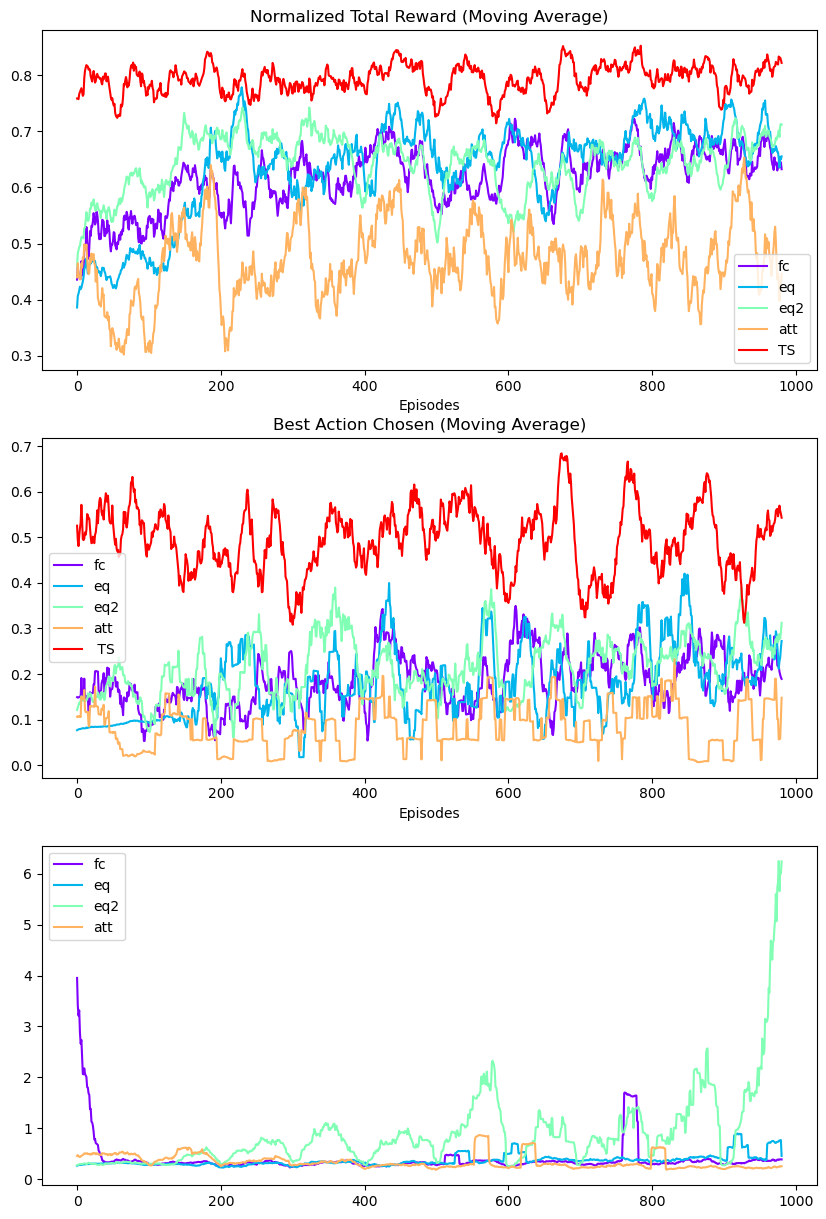

In [50]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(dqn_models)+1)))
colors2 = iter(plt.cm.rainbow(np.linspace(0, 1, len(dqn_models)+1)))
colors3 = iter(plt.cm.rainbow(np.linspace(0, 1, len(dqn_models)+1)))
window_size = 20

fig, axs = plt.subplots(3, 1, figsize=(10, 15))


x = np.arange(num_episodes - window_size + 1)  # Adjust x to match the length of the moving average

for name in dqn_models.keys():
    axs[0].plot(x, moving_average(norm_rewards_evo[name], window_size), label=name, color=next(colors))
    axs[1].plot(x, moving_average(best_action_evo[name], window_size), label=name, color=next(colors2))
    axs[2].plot(x, moving_average(loss_evo[name], window_size), label=name, color=next(colors3))
axs[0].plot(x, moving_average(norm_rewards_evo['ts'], window_size), label='TS', color=next(colors))
axs[1].plot(x, moving_average(best_action_evo['ts'], window_size), label=' TS', color=next(colors2))

axs[0].set_title('Normalized Total Reward (Moving Average)')
axs[0].set_xlabel('Episodes')
axs[0].legend()
axs[1].set_title('Best Action Chosen (Moving Average)')
axs[1].set_xlabel('Episodes')
axs[1].legend()

plt.legend()
plt.show()